In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import torch
plt.style.use('seaborn-whitegrid')

/tmp/ipykernel_3721069/2724499362.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
# results_dir = "cifar_task_specific_proj_results"
# results_dir = "grad_new_results"
results_dir = "cifar_no_updates_contrastive_results"
use_contrastive = True

# results_dir = "vanilla_results"
# use_contrastive = False

algo = "modular"
algo = "modular"
# algo = "monolithic"
dataset = "cifar100"
# dataset = "mnist"
agent = "agent_0"
# seed = "seed_0"
# seed = "seed_2"
seed = "seed_1"
numtrain = 256
# numtrain = 64
job = f"{dataset}_{algo}_numtrain_{numtrain}"
if use_contrastive:
    job += "_contrastive"
path = os.path.join(results_dir, job, dataset, algo, seed, agent)

In [3]:
df = pd.read_csv(os.path.join(path, "record.csv"))
df.head()

,train_task,test_task,test_acc,test_loss,epoch
0,0,0,0.2,1.610619,0
1,0,avg,0.2,1.610619,0
2,0,0,0.2,1.610619,0
3,0,avg,0.2,1.610619,0
4,1,0,0.2,1.610619,0


In [4]:
df["train_task"].dtype

dtype('int64')

In [5]:
# # throw away train_task that cannot be converted to int
# df = df[df["train_task"].apply(lambda x: x.isnumeric())]
# df["train_task"] = df["train_task"].astype(int)

In [6]:
max_task = int(pd.to_numeric(df["train_task"], errors="coerce").max())
max_task

19

In [7]:
def get_magma_colors(total_elements):
    start = 0.2
    stop = 0.8
    cm_subsection = np.linspace(start, stop, total_elements)
    return [matplotlib.cm.plasma(x) for x in cm_subsection]

Text(0, 0.5, 'accuracy')

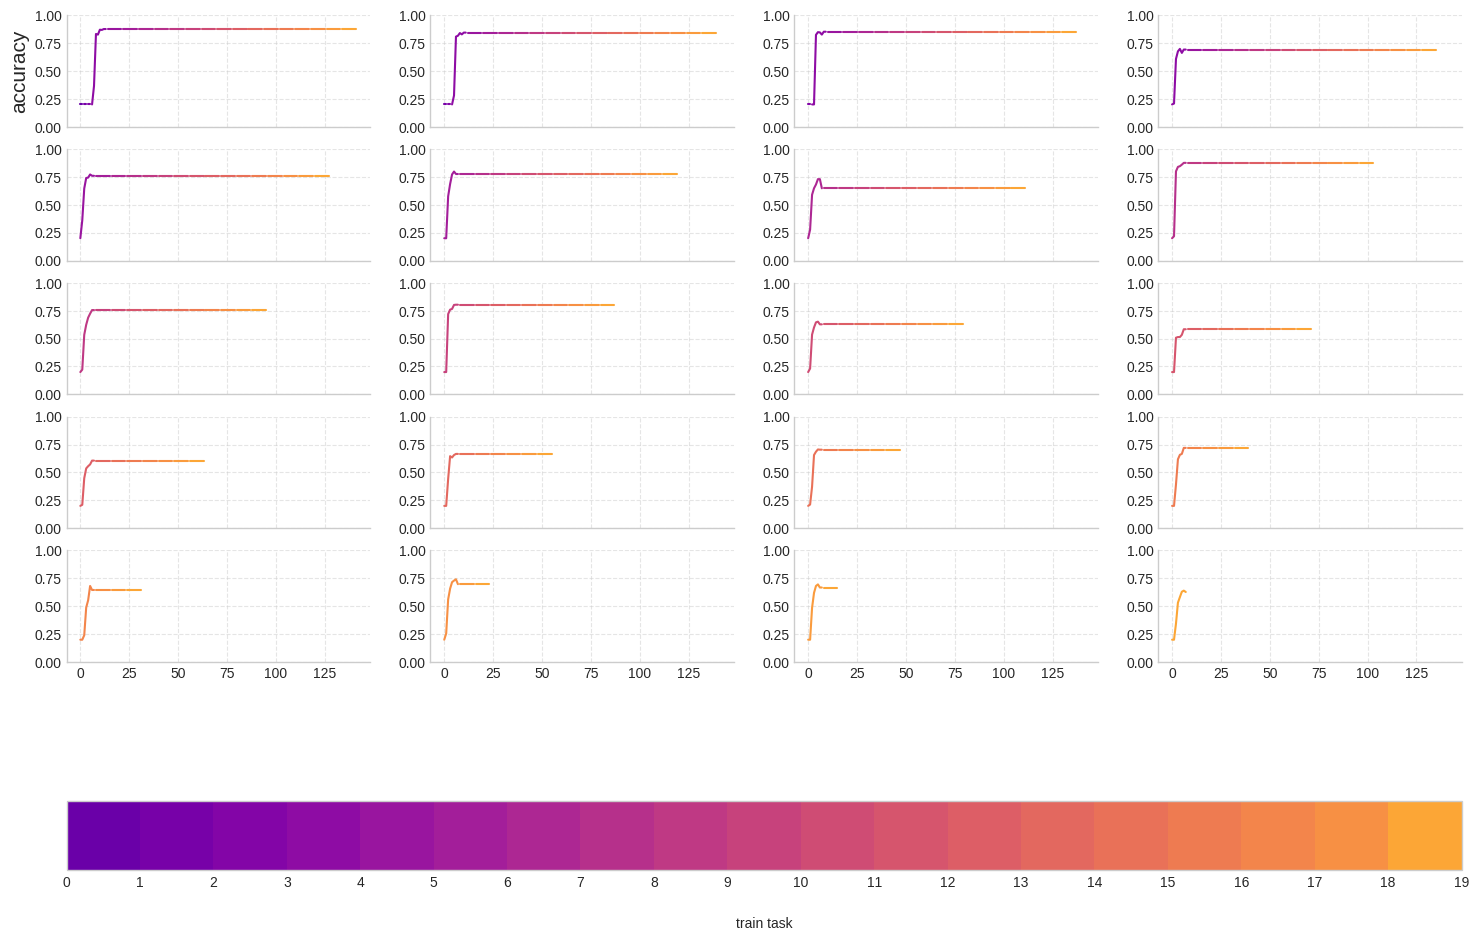

In [8]:
fig, axs = plt.subplots(figsize=(18, 12), nrows=5, ncols=4, sharex=True, sharey=False)
axs = axs.ravel()

colors = get_magma_colors(max_task+1)
for task in range(max_task+1):
    ax = axs[task]
    task_df = df[df["test_task"] == str(task)]
    # re-index the task_df
    task_df = task_df.reset_index(drop=True)
    # create "time" column from index
    task_df["time"] = task_df.index
    # create custom color map from magma

    # plot test_acc vs time colored by train_task
    # using magma discrete colormap
    for train_task in range(max_task+1):
        train_task_df = task_df[task_df["train_task"] == train_task]
        ax.plot(train_task_df["time"], train_task_df["test_acc"], color=colors[train_task], label=f"train_task={train_task}")

    ax.grid(True, which='major', linestyle='--', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # set y limit between 0 and 1
    ax.set_ylim(0, 1)


# display discrete colorbar from the colors list
# https://stackoverflow.com/questions/33689976/how-to-create-a-discrete-colorbar-in-matplotlib
cmap = matplotlib.colors.ListedColormap(colors)
bounds = np.arange(0, max_task+1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs, ticks=bounds, boundaries=bounds, spacing='proportional', orientation='horizontal')
cbar.ax.set_xticklabels([str(i) for i in range(max_task+1)])
cbar.set_label("train task", rotation=0, labelpad=20)

# labels y as accuracy
axs[0].set_ylabel("accuracy", fontsize=15)

In [9]:
# need to create a "running" epochs column, which is the sum of epochs for each train_task
# cumsum for every "n" rows
df["time"] = df.index

/tmp/ipykernel_3721069/3139382517.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=bounds, boundaries=bounds, spacing='proportional', orientation='horizontal')


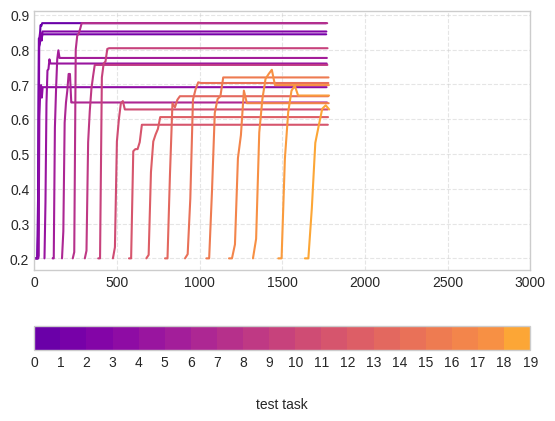

In [10]:
# for each task, plot the test_acc vs time colored by the task,
# starting with when train_task == test_task onwards (in one plot)
# colors in tab20
# colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
#             "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5"]
for task in range(max_task+1):
# for task in range(0, 5):
# for task in range(19, 20):
    task_df = df[df["train_task"] >= task]
    # get task_df of only test_task == task
    task_df = task_df[task_df["test_task"] == str(task)]
    # smooth out the test_acc
    # task_df["test_acc"] = task_df["test_acc"].rolling(5).mean()
    plt.plot(task_df["time"], task_df["test_acc"], label=f"test_task={task}",
             color=colors[task],)
plt.grid(True, which='major', linestyle='--', alpha=0.5)
plt.xlim(0, 3000)
# add colorbar
cmap = matplotlib.colors.ListedColormap(colors)
bounds = np.arange(0, max_task+1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=bounds, boundaries=bounds, spacing='proportional', orientation='horizontal')
cbar.ax.set_xticklabels([str(i) for i in range(max_task+1)])
cbar.set_label("test task", rotation=0, labelpad=20)

In [11]:
from shell.utils.metric import Metric
# m = Metric(path, num_init_tasks=4, num_init_epochs=500, num_epochs=200)
m = Metric(path, num_init_tasks=4, num_init_epochs=100, num_epochs=100)

In [12]:
m.compute_final_accuracy(reduce=None)

,train_task,test_task,test_acc,test_loss,epoch
1765,19,0,0.8760,0.533120,101
1766,19,1,0.8440,0.872791,101
1767,19,2,0.8520,0.780167,101
1768,19,3,0.6920,1.102286,101
1769,19,4,0.7600,0.867265,101
1770,19,5,0.7760,0.923947,101
1771,19,6,0.6480,1.193876,101
1772,19,7,0.8760,0.817733,101
1773,19,8,0.7560,1.095843,101
1774,19,9,0.8040,0.894013,101


In [13]:
m.compute_avg_accuracy(reduce=None)

,train_task,test_task,test_acc,test_loss,epoch
57,3,avg,0.816000,0.822091,101
105,4,avg,0.804800,0.893130,101
161,5,avg,0.800000,0.892221,101
225,6,avg,0.778286,0.921511,101
297,7,avg,0.790500,0.902715,101
377,8,avg,0.786667,0.914743,101
465,9,avg,0.788400,0.927220,101
561,10,avg,0.773818,0.946723,101
665,11,avg,0.758000,0.981268,101
777,12,avg,0.746308,1.010745,101


In [14]:
pd.read_csv(os.path.join(path, "add_modules_record.csv"))

,task_id,update_acc,no_update_acc,num_components,add_new_module
0,4,0.778443,0.642715,5,True
1,5,0.823875,0.688845,6,True
2,6,0.665314,0.640974,6,False
3,7,0.885602,0.806706,7,True
4,8,0.756701,0.680412,8,True
5,9,0.835700,0.762677,9,True
6,10,0.640657,0.583162,10,True
7,11,0.556886,0.518962,11,True
8,12,0.605941,0.564356,12,True
9,13,0.651731,0.598778,13,True


In [15]:
# load the net checkpoint to see the architecture
checkpt = torch.load(os.path.join(path, "task_19", "checkpoint.pt"))
net = checkpt['model_state_dict']

In [16]:
from pprint import pprint
pprint(net.keys())

odict_keys(['structure.0', 'structure.1', 'structure.2', 'structure.3', 'structure.4', 'structure.5', 'structure.6', 'structure.7', 'structure.8', 'structure.9', 'structure.10', 'structure.11', 'structure.12', 'structure.13', 'structure.14', 'structure.15', 'structure.16', 'structure.17', 'structure.18', 'structure.19', 'components.0.weight', 'components.0.bias', 'components.1.weight', 'components.1.bias', 'components.2.weight', 'components.2.bias', 'components.3.weight', 'components.3.bias', 'components.4.weight', 'components.4.bias', 'components.5.weight', 'components.5.bias', 'components.6.weight', 'components.6.bias', 'components.7.weight', 'components.7.bias', 'components.8.weight', 'components.8.bias', 'components.9.weight', 'components.9.bias', 'components.10.weight', 'components.10.bias', 'components.11.weight', 'components.11.bias', 'components.12.weight', 'components.12.bias', 'components.13.weight', 'components.13.bias', 'components.14.weight', 'components.14.bias', 'compone

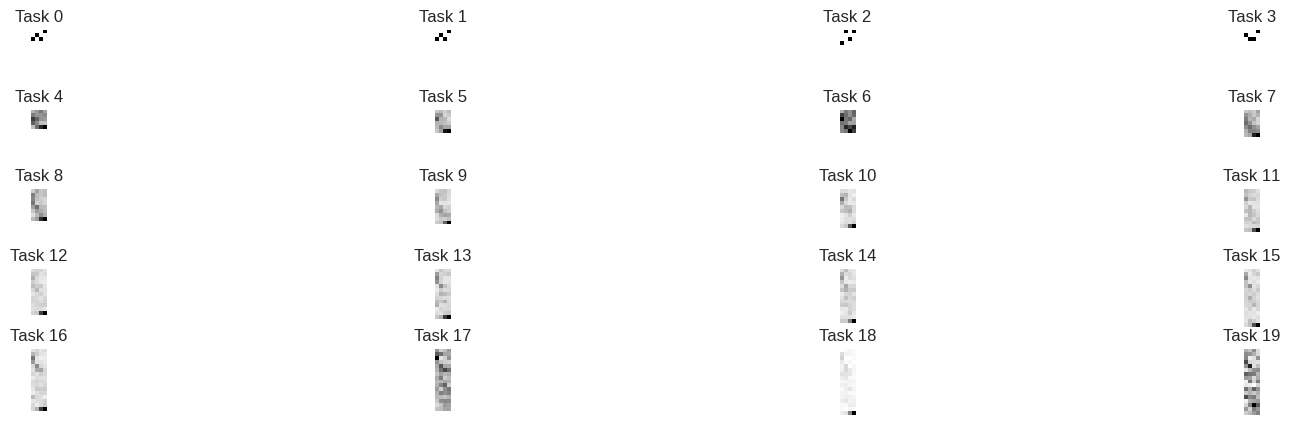

In [17]:
fig, axs = plt.subplots(figsize=(20, 5), nrows=5, ncols=4, sharex=True, sharey=False)
axs = axs.ravel()
for task in range(max_task+1):
# for task in range(1):
    # ax = axes[task]
    struct = net[f'structure.{task}'].cpu()
    # softmax the structure
    struct = torch.nn.functional.softmax(struct, dim=0)
    # ax = fig.add_subplot(20, 1, task+1)
    ax = axs[task]
    ax.imshow(struct)
    ax.axis("off")
    ax.set_title(f"Task {task}")

In [18]:
struct.shape

torch.Size([17, 4])

In [19]:
net['projector.19.2.weight'].shape

torch.Size([32, 200])